## This notebook details changes made to my model of turbulence for the operator learning project

27/06/25


In the project meeting on Friday 20th June, we had difficulty making the energy spectrum fit the theoretical $k^{-5/3}$ slope. We concluded that this is down to the loss of energy when projecting the vector field to make it divergence free. This is true.

However I realised that I had not generated coefficient for the Fourier modes in a Hermetian symmetric way: in order for the inverse FFT to give a real number (instead of complex) you need conjugate Fourier modes to have congugate complex coefficients. I had previously been taking the real part of the complex number gained from inverse FFT which loses a lot of energy. Below shows the corrected code with a plot of the energy spectrum **before and after projecting to divergence free space**.


### Current turbulence parameters

$\text{Re} = 10000$, 
$\text{Characteristic Length = 0.2}$,
$ \nu = 0.001$

This means the target RMS vecocity is $50$.

### Choosing energy spectrum scaling

In Fourier space the wave number increases as we move out in a shell about the origin. We discretise Fourier space, compartmentalising modes in these shells. 
By considering the area of a torus we can show that in a shell of radius $k$ with width $dk$, the number of Fourier modes scales according to $k dk$. 

We want the total energy in each shell to scale as $E(k) \propto k^{-5/3}$.

Then the energy per individual mode should scale as 
$$\frac{E(k)}{\text{number of modes}} \approx k^{-8/3}.$$

Since the energy per mode scales according to $|\hat{u}(k)|^2$ we want the coefficients of the Fourier modes to scale according to $|\hat{u}(k)| \propto k^{-4/3}$.

=== DIAGNOSTIC INFO ===
Domain size: 1
Grid points: 1000 x 1000
kfmin: 6.283, kfmax: 125.664
Number of active modes: 1244
Total energy before projection: 1.93e+05
Total energy after projection: 7.65e+04


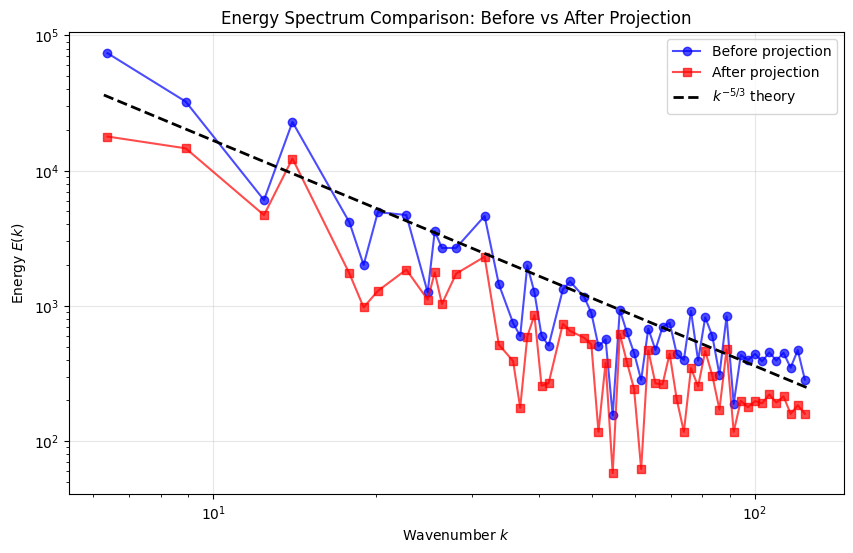


=== ENERGY SPECTRUM ANALYSIS ===
Fitted slope before projection: -0.91 (should be ≈ -1.67 for k^(-5/3))
Fitted slope after projection: -0.75

=== PHYSICAL SPACE VERIFICATION ===
Max imaginary part in ux: 2.456828814815732e-19
Max imaginary part in uy: 2.573731446780965e-19
rms current 0.0003819541099957112

=== FINAL RESULTS ===
Target Reynolds number: 10000
Actual Reynolds number: 10000.00
Target RMS velocity: 50.000000
Final RMS velocity: 50.000000
Velocity field shape: (1000, 1000)
Max velocity magnitude: 114.849323
Energy distribution check - mean energy: 5.86e+01


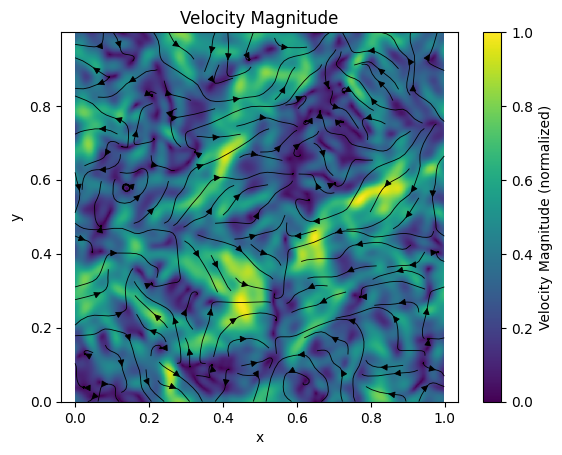

In [ ]:
import numpy as np
from numpy.fft import ifft2
import matplotlib.pyplot as plt

L = 0.2
Reynolds = 10000
nu = 0.001
eps_1, eps_2 = 0, 0

# Validate resolution
N_x, N_y = 1000, 1000

# ===========================
# SET UP FOURIER SPACE
# ===========================
# Store characteristic length L for Reynolds number calculation
L_char = L
# Domain size for spectral method
L_domain = 1 + 2 * max(eps_1, eps_2)

# Define grid and spacing in real space
x, y = np.linspace(0, 1, N_x, endpoint=False), np.linspace(0, 1, N_y, endpoint=False)
dx, dy = L_domain / N_x, L_domain / N_y

# Define grid and spacing in Fourier space
k_xv = 2 * np.pi * np.fft.fftfreq(N_x, d=dx)
k_yv = 2 * np.pi * np.fft.fftfreq(N_y, d=dy)
kx, ky = np.meshgrid(k_xv, k_yv, indexing='ij')
k2 = kx**2 + ky**2  # Squared wavenumber magnitude

# ===========================
# GENERATE HERMITIAN SYMMETRIC MODES
# ===========================
def generate_hermitian_random_field(shape, active_modes, amplitude, scaling):
    """
    Generate a random field with proper Hermitian symmetry for real IFFT.
    Only generates the independent modes and sets their conjugates.
    """
    N_x, N_y = shape
    field = np.zeros((N_x, N_y), dtype=complex)
    
    for i in range(N_x):
        for j in range(N_y):
            if not active_modes[i, j]:
                continue
                
            # Find conjugate indices
            i_conj = (-i) % N_x
            j_conj = (-j) % N_y
            
            # Handle special cases that must be real
            if (i == 0 and j == 0) or \
               (N_x % 2 == 0 and i == N_x//2 and j == 0) or \
               (N_y % 2 == 0 and i == 0 and j == N_y//2) or \
               (N_x % 2 == 0 and N_y % 2 == 0 and i == N_x//2 and j == N_y//2):
                # These modes must be real
                field[i, j] = amplitude * scaling[i, j] * np.random.randn()
            else:
                # Check if we've already set this mode via its conjugate
                if field[i, j] != 0:
                    continue
                    
                # Generate complex random coefficient
                coeff = amplitude * scaling[i, j] * (np.random.randn() + 1j * np.random.randn())
                field[i, j] = coeff
                
                # Set conjugate symmetric coefficient
                field[i_conj, j_conj] = np.conj(coeff)
    
    return field

# ===========================
# PROJECT TO DIVERGENCE-FREE SPACE
# ===========================
def P(ux, uy):
    """Projection operator to ensure the velocity field is divergence-free"""
    # Avoid division by zero at k=0
    k2_safe = k2.copy()
    k2_safe[0, 0] = 1.0
    
    # Compute divergence in Fourier space
    uxprojected = ux * (1 - kx**2/k2_safe) - uy * kx*ky/k2_safe
    uyprojected = uy * (1 - ky**2/k2_safe) - ux * kx*ky/k2_safe
    
    # Set DC component to zero (no mean flow)
    uxprojected[0, 0] = 0
    uyprojected[0, 0] = 0
    
    return uxprojected, uyprojected

# ===========================
# INITIALIZE VELOCITY FIELD
# ===========================
# Define wavenumber and Nyquist limit
k = np.sqrt(k2)
k_nyquist = np.pi * N_x / L_domain

# Select modes based on physical scales
kfmin = 2 * np.pi / L_domain  # Largest scale ~ domain size
kfmax = min(k_nyquist / 2, 20 * kfmin)  # Limit by resolution and reasonable range

# Use logarithmic spacing for mode selection
log_k = np.log10(k + 1e-10)  # Avoid log(0) errors
log_kfmin = np.log10(kfmin)
log_kfmax = np.log10(kfmax)

# Select modes in logarithmic bands
initModes = (log_k >= log_kfmin) & (log_k <= log_kfmax)
n_active = np.sum(initModes)

# Create random Fourier modes with proper Hermitian symmetry
ux = np.zeros((N_x, N_y), dtype=complex)
uy = np.zeros((N_x, N_y), dtype=complex)

# Generate random coefficients with proper normalization
amplitude = 1e3  # Reduced from 1e4 for better numerical stability

# Apply energy spectrum scaling (Kolmogorov-like for 2D)
scaling = np.ones_like(k)
mask = (k > 0) & initModes
scaling[mask] = k[mask]**(-4/3)  # For E(k) ~ k^(-5/3): amplitude ~ k^(-4/3)

# Check energy spectrum before and after projection
print("=== DIAGNOSTIC INFO ===")
print(f"Domain size: {L_domain}")
print(f"Grid points: {N_x} x {N_y}")
print(f"kfmin: {kfmin:.3f}, kfmax: {kfmax:.3f}")
print(f"Number of active modes: {np.sum(initModes)}")

# Generate fields and check energy before projection
ux_before = generate_hermitian_random_field((N_x, N_y), initModes, amplitude, scaling)
uy_before = generate_hermitian_random_field((N_x, N_y), initModes, amplitude, scaling)

# Apply projection
ux = ux_before.copy()
uy = uy_before.copy()
ux, uy = P(ux, uy)

# Compare energy spectra
energy_before = 0.5 * (np.abs(ux_before)**2 + np.abs(uy_before)**2)
energy_after = 0.5 * (np.abs(ux)**2 + np.abs(uy)**2)

print(f"Total energy before projection: {np.sum(energy_before):.2e}")
print(f"Total energy after projection: {np.sum(energy_after):.2e}")

# === PLOT ENERGY SPECTRA BEFORE AND AFTER PROJECTION ===
# Common setup for both spectra
k_mag = np.sqrt(kx**2 + ky**2)
k_mag_flat = k_mag.flatten()

# Energy spectrum BEFORE projection
E_k_before_flat = energy_before.flatten()
k_bins = np.logspace(np.log10(kfmin), np.log10(kfmax), num=100)
k_center = np.sqrt(k_bins[:-1] * k_bins[1:])  # Geometric mean for log bins

E_spectrum_before, _ = np.histogram(k_mag_flat, bins=k_bins, weights=E_k_before_flat)
mask_before = E_spectrum_before > 0
k_center_before = k_center[mask_before]
E_spectrum_before = E_spectrum_before[mask_before]

# Energy spectrum AFTER projection
E_k_after_flat = energy_after.flatten()
E_spectrum_after, _ = np.histogram(k_mag_flat, bins=k_bins, weights=E_k_after_flat)
mask_after = E_spectrum_after > 0
k_center_after = k_center[mask_after]
E_spectrum_after = E_spectrum_after[mask_after]

# Theoretical k^(-5/3) slope
k_theory = np.logspace(np.log10(kfmin), np.log10(kfmax), 50)
slope_theory = k_theory**(-5/3)

# Scale theory to match before-projection spectrum
if len(E_spectrum_before) > 0:
    # Find overlapping k range
    k_overlap = k_center_before[(k_center_before >= k_theory.min()) & (k_center_before <= k_theory.max())]
    if len(k_overlap) > 0:
        # Scale theory to match at middle of range
        mid_idx = len(k_overlap) // 2
        k_match = k_overlap[mid_idx]
        E_match = E_spectrum_before[np.argmin(np.abs(k_center_before - k_match))]
        theory_match = k_match**(-5/3)
        slope_theory *= E_match / theory_match



# Plot energy spectra together for direct comparison
plt.figure(figsize=(10, 6))
plt.loglog(k_center_before, E_spectrum_before, 'o-', label='Before projection', color='blue', alpha=0.7)
plt.loglog(k_center_after, E_spectrum_after, 's-', label='After projection', color='red', alpha=0.7)
plt.loglog(k_theory, slope_theory, 'k--', label=r'$k^{-5/3}$ theory', linewidth=2)
plt.xlabel('Wavenumber $k$')
plt.ylabel('Energy $E(k)$')
plt.title('Energy Spectrum Comparison: Before vs After Projection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
print("\n=== ENERGY SPECTRUM ANALYSIS ===")
if len(k_center_before) > 5:
    # Check slope of before-projection spectrum
    log_k = np.log10(k_center_before)
    log_E = np.log10(E_spectrum_before)
    
    # Fit line to middle portion of spectrum (inertial range)
    mid_start = len(log_k) // 4
    mid_end = 3 * len(log_k) // 4
    
    if mid_end > mid_start + 1:
        coeffs = np.polyfit(log_k[mid_start:mid_end], log_E[mid_start:mid_end], 1)
        fitted_slope = coeffs[0]
        print(f"Fitted slope before projection: {fitted_slope:.2f} (should be ≈ -1.67 for k^(-5/3))")
        
        # Same for after projection
        if len(k_center_after) > 5:
            log_k_after = np.log10(k_center_after)
            log_E_after = np.log10(E_spectrum_after)
            mid_end_after = min(mid_end, len(log_k_after))
            mid_start_after = min(mid_start, len(log_k_after) - 2)
            
            if mid_end_after > mid_start_after + 1:
                coeffs_after = np.polyfit(log_k_after[mid_start_after:mid_end_after], 
                                        log_E_after[mid_start_after:mid_end_after], 1)
                #As we work in logspace we have a linear relationship for the epected power law. This is why we take the first coefficient below.
                fitted_slope_after = coeffs_after[0]
                print(f"Fitted slope after projection: {fitted_slope_after:.2f}")

# Generate final Hermitian symmetric random fields
ux = generate_hermitian_random_field((N_x, N_y), initModes, amplitude, scaling)
uy = generate_hermitian_random_field((N_x, N_y), initModes, amplitude, scaling)

# Ensure field is divergence-free
ux, uy = P(ux, uy)

# Transform to physical space (should be exactly real now)
ux_physical = ifft2(ux)
uy_physical = ifft2(uy)

# Verify that imaginary parts are negligible
print("\n=== PHYSICAL SPACE VERIFICATION ===")
print("Max imaginary part in ux:", np.max(np.abs(np.imag(ux_physical))))
print("Max imaginary part in uy:", np.max(np.abs(np.imag(uy_physical))))

# Extract real parts (should be exactly real already)
ux_physical = np.real(ux_physical)
uy_physical = np.real(uy_physical)

# ===========================
# NORMALIZE TO TARGET RMS
# ===========================
rms_target = (Reynolds * nu) / L_char
current_rms = np.sqrt(np.mean(ux_physical**2 + uy_physical**2))
print("rms current", current_rms)

if current_rms < 1e-10:
    raise ValueError(f"RMS velocity too small ({current_rms}). Try increasing initial amplitude.")

# Scale velocity field to match required Reynolds number
scaling_factor = rms_target / current_rms
ux_physical *= scaling_factor
uy_physical *= scaling_factor

# Verify final Reynolds number
final_rms = np.sqrt(np.mean(ux_physical**2 + uy_physical**2))
actual_reynolds = (final_rms * L_char) / nu

print("\n=== FINAL RESULTS ===")
print(f"Target Reynolds number: {Reynolds}")
print(f"Actual Reynolds number: {actual_reynolds:.2f}")
print(f"Target RMS velocity: {rms_target:.6f}")
print(f"Final RMS velocity: {final_rms:.6f}")
print(f"Velocity field shape: {ux_physical.shape}")
print(f"Max velocity magnitude: {np.max(np.sqrt(ux_physical**2 + uy_physical**2)):.6f}")

# Check energy spectrum
k_modes = k[initModes]
energy_spectrum = 0.5 * (np.abs(ux[initModes])**2 + np.abs(uy[initModes])**2)
print(f"Energy distribution check - mean energy: {np.mean(energy_spectrum):.2e}")


# # ===========================
# # VISUALIZE RESULTS
# # ===========================

# # Velocity magnitude
velocity_mag = np.sqrt(ux_physical**2 + uy_physical**2)
#plt.subplot(2, 2, 1)
plt.pcolormesh(x, y, velocity_mag, cmap='viridis', shading='auto', 
               vmin=0, vmax=np.max(velocity_mag))
plt.streamplot(x, y, ux_physical, uy_physical, color="black", linewidth=0.6)
plt.colorbar(label='Velocity Magnitude (normalized)')


plt.title('Velocity Magnitude')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
#plt.savefig("turbulence.png", dpi=300, bbox_inches="tight")
plt.show()



A natural question is whether there is some way to correct the energy loss while maintaining a divergence free field.

##  Curved domains
Now I try the same but for a curved domain. Recall that I generate a rectangle that covers the curved domain and only use the part inside the domain for the PDE problems.

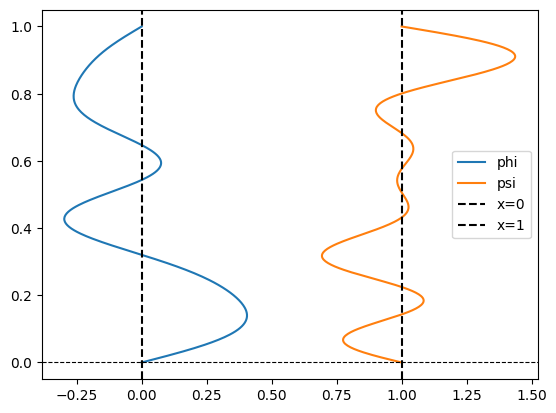

=== DIAGNOSTIC INFO ===
Domain size: 1.734843420983911
Grid points: 1000 x 1000
kfmin: 3.622, kfmax: 72.435
Number of active modes: 1244
Total energy before projection: 6.43e+03
Total energy after projection: 3.43e+03


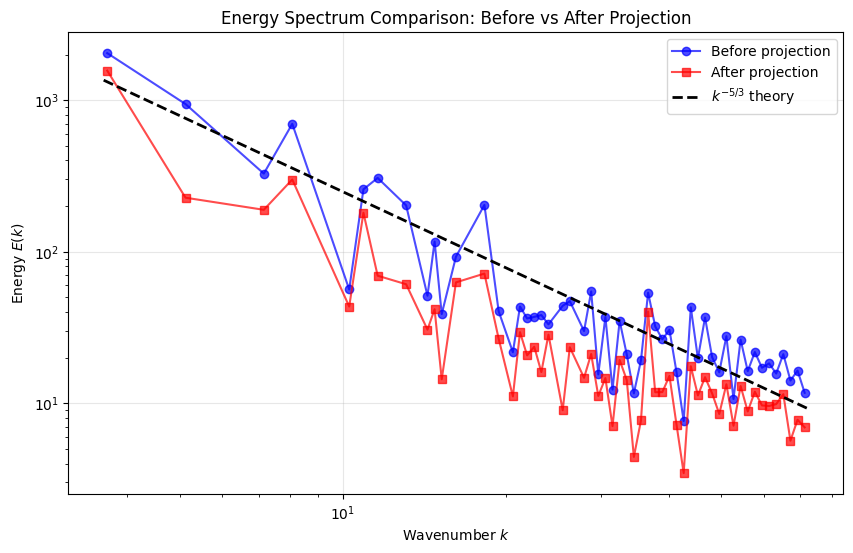


=== ENERGY SPECTRUM ANALYSIS ===
Fitted slope before projection: -0.67 (should be ≈ -1.67 for k^(-5/3))
Fitted slope after projection: -0.95

=== PHYSICAL SPACE VERIFICATION ===
Max imaginary part in ux: 6.22943343371826e-20
Max imaginary part in uy: 6.015403575954966e-20

=== FINAL RESULTS ===
Target Reynolds number: 10000
Actual Reynolds number: 10000.00
Target RMS velocity: 5.000000
Final RMS velocity: 5.000000
Velocity field shape: (1000, 1000)
Max velocity magnitude: 10.778759
Energy distribution check - mean energy: 3.84e+00


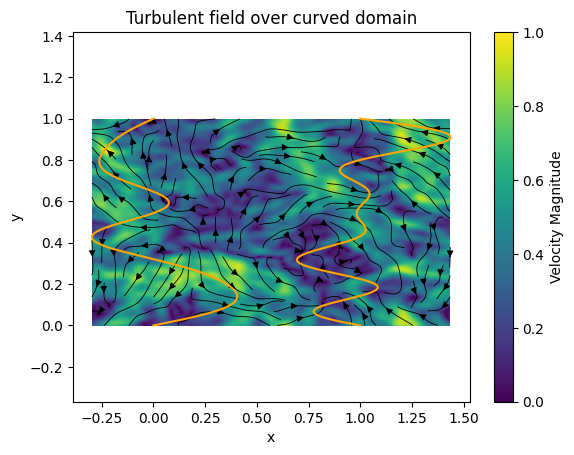

In [2]:
import numpy as np
from numpy.fft import ifft2
import matplotlib.pyplot as plt
from Trig_polynomial_boundary import generate_trig_functions

L = 0.02
Reynolds = 10000
nu = 0.00001
eps_trig = 0.3
while True:
        # Generate boundaries via parametrisations phi and psi
            phi, psi, Omega = generate_trig_functions(Print=False)
            
            # Check separation across the domain
            y_vals = np.linspace(0, 1, 400)
            x_vals1 = np.vectorize(phi)(y_vals)
            x_vals2 = np.vectorize(psi)(y_vals)
            
            # Check if adequate separation exists everywhere
            if np.all(x_vals2 > x_vals1 + eps_trig):
                #Finding episilon neighbourhoods for generating turbulence in domain (generation is on a super-square).
                # Get values less than or equal to 0
                negative_vals_1 = x_vals1[x_vals1 <= 0]
                vals_2 = x_vals2[x_vals2>=1]
                # Find the largest in magnitude (which is closest to 0)
                largest_neg = negative_vals_1[np.argmax(np.abs(negative_vals_1))]
                largest_pos = vals_2[np.argmax(np.abs(vals_2))]
                #Find the largest in magnitude 
                eps_1 = -largest_neg
                eps_2 = largest_pos-1
                break  # Found non-overlapping functions

#####
# Plotting Curved Domain
#####

plt.plot(x_vals1, y_vals, label="phi")
plt.plot(x_vals2, y_vals, label="psi")
# Add vertical dashed line at x=0
plt.axvline(x=0, color='black', linestyle='--', label='x=0')
# Add vertical dashed line at x=1
plt.axvline(x=1, color='black', linestyle='--', label='x=1')
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.legend()
plt.show()


# Validate resolution
N_x, N_y = 1000, 1000

# ===========================
# SET UP FOURIER SPACE
# ===========================
# Store characteristic length L for Reynolds number calculation
L_char = L

#### This is new code trying to fit turbulence to domain better

if eps_1 > 0:
    L_left = largest_neg
else:
    L_left = 0
if eps_2 > 0:
    L_right = largest_pos
else:
    L_right = 1

# Domain size for spectral method
L_domain = L_right - L_left

# Define grid and spacing in real space
x, y = np.linspace(L_left, L_right, N_x, endpoint=False), np.linspace(0, 1, N_y, endpoint=False)
dx, dy = L_domain / N_x, L_domain / N_y

# Define grid and spacing in Fourier space
k_xv = 2 * np.pi * np.fft.fftfreq(N_x, d=dx)
k_yv = 2 * np.pi * np.fft.fftfreq(N_y, d=dy)
kx, ky = np.meshgrid(k_xv, k_yv, indexing='ij')
k2 = kx**2 + ky**2  # Squared wavenumber magnitude

# ===========================
# GENERATE HERMITIAN SYMMETRIC MODES
# ===========================
def generate_hermitian_random_field(shape, active_modes, amplitude, scaling):
    """
    Generate a random field with proper Hermitian symmetry for real IFFT.
    Only generates the independent modes and sets their conjugates.
    """
    N_x, N_y = shape
    field = np.zeros((N_x, N_y), dtype=complex)
    
    for i in range(N_x):
        for j in range(N_y):
            if not active_modes[i, j]:
                continue
                
            # Find conjugate indices
            i_conj = (-i) % N_x
            j_conj = (-j) % N_y
            
            # Handle special cases that must be real
            if (i == 0 and j == 0) or \
               (N_x % 2 == 0 and i == N_x//2 and j == 0) or \
               (N_y % 2 == 0 and i == 0 and j == N_y//2) or \
               (N_x % 2 == 0 and N_y % 2 == 0 and i == N_x//2 and j == N_y//2):
                # These modes must be real
                field[i, j] = amplitude * scaling[i, j] * np.random.randn()
            else:
                # Check if we've already set this mode via its conjugate
                if field[i, j] != 0:
                    continue
                    
                # Generate complex random coefficient
                coeff = amplitude * scaling[i, j] * (np.random.randn() + 1j * np.random.randn())
                field[i, j] = coeff
                
                # Set conjugate symmetric coefficient
                field[i_conj, j_conj] = np.conj(coeff)
    
    return field

# ===========================
# PROJECT TO DIVERGENCE-FREE SPACE
# ===========================
def P(ux, uy):
    """Projection operator to ensure the velocity field is divergence-free"""
    # Avoid division by zero at k=0
    k2_safe = k2.copy()
    k2_safe[0, 0] = 1.0
    
    # Compute divergence in Fourier space
    uxprojected = ux * (1 - kx**2/k2_safe) - uy * kx*ky/k2_safe
    uyprojected = uy * (1 - ky**2/k2_safe) - ux * kx*ky/k2_safe
    
    # Set DC component to zero (no mean flow)
    uxprojected[0, 0] = 0
    uyprojected[0, 0] = 0
    
    return uxprojected, uyprojected

# ===========================
# INITIALIZE VELOCITY FIELD
# ===========================
# Define wavenumber and Nyquist limit
k = np.sqrt(k2)
k_nyquist = np.pi * N_x / L_domain

# Select modes based on physical scales
kfmin = 2 * np.pi / L_domain  # Largest scale ~ domain size
kfmax = min(k_nyquist / 2, 20 * kfmin)  # Limit by resolution and reasonable range

# Use logarithmic spacing for mode selection
log_k = np.log10(k + 1e-10)  # Avoid log(0) errors
log_kfmin = np.log10(kfmin)
log_kfmax = np.log10(kfmax)

# Select modes in logarithmic bands
initModes = (log_k >= log_kfmin) & (log_k <= log_kfmax)
n_active = np.sum(initModes)

# Create random Fourier modes with proper Hermitian symmetry
ux = np.zeros((N_x, N_y), dtype=complex)
uy = np.zeros((N_x, N_y), dtype=complex)

# Generate random coefficients with proper normalization
amplitude = 1e2  # Reduced from 1e4 for better numerical stability

# Apply energy spectrum scaling (Kolmogorov-like for 2D)
scaling = np.ones_like(k)
mask = (k > 0) & initModes
scaling[mask] = k[mask]**(-4/3)  # For E(k) ~ k^(-5/3): amplitude ~ k^(-4/3)

# Check energy spectrum before and after projection
print("=== DIAGNOSTIC INFO ===")
print(f"Domain size: {L_domain}")
print(f"Grid points: {N_x} x {N_y}")
print(f"kfmin: {kfmin:.3f}, kfmax: {kfmax:.3f}")
print(f"Number of active modes: {np.sum(initModes)}")

# Generate fields and check energy before projection
ux_before = generate_hermitian_random_field((N_x, N_y), initModes, amplitude, scaling)
uy_before = generate_hermitian_random_field((N_x, N_y), initModes, amplitude, scaling)

# Apply projection
ux = ux_before.copy()
uy = uy_before.copy()
ux, uy = P(ux, uy)

# Compare energy spectra
energy_before = 0.5 * (np.abs(ux_before)**2 + np.abs(uy_before)**2)
energy_after = 0.5 * (np.abs(ux)**2 + np.abs(uy)**2)

print(f"Total energy before projection: {np.sum(energy_before):.2e}")
print(f"Total energy after projection: {np.sum(energy_after):.2e}")

# === PLOT ENERGY SPECTRA BEFORE AND AFTER PROJECTION ===
# Common setup for both spectra
k_mag = np.sqrt(kx**2 + ky**2)
k_mag_flat = k_mag.flatten()

# Energy spectrum BEFORE projection
E_k_before_flat = energy_before.flatten()
k_bins = np.logspace(np.log10(kfmin), np.log10(kfmax), num=100)
k_center = np.sqrt(k_bins[:-1] * k_bins[1:])  # Geometric mean for log bins

E_spectrum_before, _ = np.histogram(k_mag_flat, bins=k_bins, weights=E_k_before_flat)
mask_before = E_spectrum_before > 0
k_center_before = k_center[mask_before]
E_spectrum_before = E_spectrum_before[mask_before]

# Energy spectrum AFTER projection
E_k_after_flat = energy_after.flatten()
E_spectrum_after, _ = np.histogram(k_mag_flat, bins=k_bins, weights=E_k_after_flat)
mask_after = E_spectrum_after > 0
k_center_after = k_center[mask_after]
E_spectrum_after = E_spectrum_after[mask_after]

# Theoretical k^(-5/3) slope
k_theory = np.logspace(np.log10(kfmin), np.log10(kfmax), 50)
slope_theory = k_theory**(-5/3)

# Scale theory to match before-projection spectrum
if len(E_spectrum_before) > 0:
    # Find overlapping k range
    k_overlap = k_center_before[(k_center_before >= k_theory.min()) & (k_center_before <= k_theory.max())]
    if len(k_overlap) > 0:
        # Scale theory to match at middle of range
        mid_idx = len(k_overlap) // 2
        k_match = k_overlap[mid_idx]
        E_match = E_spectrum_before[np.argmin(np.abs(k_center_before - k_match))]
        theory_match = k_match**(-5/3)
        slope_theory *= E_match / theory_match



# Plot energy spectra together for direct comparison
plt.figure(figsize=(10, 6))
plt.loglog(k_center_before, E_spectrum_before, 'o-', label='Before projection', color='blue', alpha=0.7)
plt.loglog(k_center_after, E_spectrum_after, 's-', label='After projection', color='red', alpha=0.7)
plt.loglog(k_theory, slope_theory, 'k--', label=r'$k^{-5/3}$ theory', linewidth=2)
plt.xlabel('Wavenumber $k$')
plt.ylabel('Energy $E(k)$')
plt.title('Energy Spectrum Comparison: Before vs After Projection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
print("\n=== ENERGY SPECTRUM ANALYSIS ===")
if len(k_center_before) > 5:
    # Check slope of before-projection spectrum
    log_k = np.log10(k_center_before)
    log_E = np.log10(E_spectrum_before)
    
    # Fit line to middle portion of spectrum (inertial range)
    mid_start = len(log_k) // 4
    mid_end = 3 * len(log_k) // 4
    
    if mid_end > mid_start + 1:
        coeffs = np.polyfit(log_k[mid_start:mid_end], log_E[mid_start:mid_end], 1)
        fitted_slope = coeffs[0]
        print(f"Fitted slope before projection: {fitted_slope:.2f} (should be ≈ -1.67 for k^(-5/3))")
        
        # Same for after projection
        if len(k_center_after) > 5:
            log_k_after = np.log10(k_center_after)
            log_E_after = np.log10(E_spectrum_after)
            mid_end_after = min(mid_end, len(log_k_after))
            mid_start_after = min(mid_start, len(log_k_after) - 2)
            
            if mid_end_after > mid_start_after + 1:
                coeffs_after = np.polyfit(log_k_after[mid_start_after:mid_end_after], 
                                        log_E_after[mid_start_after:mid_end_after], 1)
                #As we work in logspace we have a linear relationship for the epected power law. This is why we take the first coefficient below.
                fitted_slope_after = coeffs_after[0]
                print(f"Fitted slope after projection: {fitted_slope_after:.2f}")

# Generate final Hermitian symmetric random fields
ux = generate_hermitian_random_field((N_x, N_y), initModes, amplitude, scaling)
uy = generate_hermitian_random_field((N_x, N_y), initModes, amplitude, scaling)

# Ensure field is divergence-free
ux, uy = P(ux, uy)

# Transform to physical space (should be exactly real now)
ux_physical = ifft2(ux)
uy_physical = ifft2(uy)

# Verify that imaginary parts are negligible
print("\n=== PHYSICAL SPACE VERIFICATION ===")
print("Max imaginary part in ux:", np.max(np.abs(np.imag(ux_physical))))
print("Max imaginary part in uy:", np.max(np.abs(np.imag(uy_physical))))

# Extract real parts (should be exactly real already)
ux_physical = np.real(ux_physical)
uy_physical = np.real(uy_physical)

# ===========================
# NORMALIZE TO TARGET RMS
# ===========================
rms_target = (Reynolds * nu) / L_char
current_rms = np.sqrt(np.mean(ux_physical**2 + uy_physical**2))

if current_rms < 1e-10:
    raise ValueError(f"RMS velocity too small ({current_rms}). Try increasing initial amplitude.")

# Scale velocity field to match required Reynolds number
scaling_factor = rms_target / current_rms
ux_physical *= scaling_factor
uy_physical *= scaling_factor

# Verify final Reynolds number
final_rms = np.sqrt(np.mean(ux_physical**2 + uy_physical**2))
actual_reynolds = (final_rms * L_char) / nu

print("\n=== FINAL RESULTS ===")
print(f"Target Reynolds number: {Reynolds}")
print(f"Actual Reynolds number: {actual_reynolds:.2f}")
print(f"Target RMS velocity: {rms_target:.6f}")
print(f"Final RMS velocity: {final_rms:.6f}")
print(f"Velocity field shape: {ux_physical.shape}")
print(f"Max velocity magnitude: {np.max(np.sqrt(ux_physical**2 + uy_physical**2)):.6f}")

# Check energy spectrum
k_modes = k[initModes]
energy_spectrum = 0.5 * (np.abs(ux[initModes])**2 + np.abs(uy[initModes])**2)
print(f"Energy distribution check - mean energy: {np.mean(energy_spectrum):.2e}")


# # ===========================
# # VISUALIZE RESULTS
# # ===========================

# # Velocity magnitude
velocity_mag = np.sqrt(ux_physical**2 + uy_physical**2)
#plt.subplot(2, 2, 1)
plt.pcolormesh(x, y, velocity_mag, cmap='viridis', shading='auto')
plt.streamplot(x,y,ux_physical, uy_physical, color="black", linewidth =0.6 )

plt.plot(x_vals1, y_vals, label="phi", color = "orange")
plt.plot(x_vals2, y_vals, label="psi", color = "orange")

plt.colorbar(label='Velocity Magnitude')
plt.title('Turbulent field over curved domain')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
#plt.savefig("turbulence.png", dpi=300, bbox_inches="tight")
plt.show()


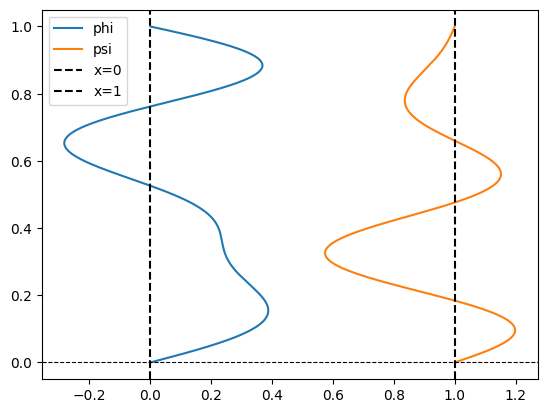

In [39]:
eps_trig = 0.3
phi, psi, Omega = generate_trig_functions(Print=False)
            
# Check separation across the domain
y_vals = np.linspace(0, 1, 400)
x_vals1 = np.vectorize(phi)(y_vals)
x_vals2 = np.vectorize(psi)(y_vals)
            
            # Check if adequate separation exists everywhere
if np.all(x_vals2 > x_vals1 + eps_trig):
                #Finding episilon neighbourhoods for generating turbulence in domain (generation is on a super-square).
                # Get values less than or equal to 0
    negative_vals_1 = x_vals1[x_vals1 <= 0]
    vals_2 = x_vals2[x_vals2>=1]
                # Find the largest in magnitude (which is closest to 0)
    largest_neg = negative_vals_1[np.argmax(np.abs(negative_vals_1))]
    largest_pos = vals_2[np.argmax(np.abs(vals_2))]
                #Find the largest in magnitude 
    eps_1 = -largest_neg
    eps_2 = largest_pos-1
                

#####
# Plotting Curved Domain
#####

plt.plot(x_vals1, y_vals, label="phi")
plt.plot(x_vals2, y_vals, label="psi")
# Add vertical dashed line at x=0
plt.axvline(x=0, color='black', linestyle='--', label='x=0')
# Add vertical dashed line at x=1
plt.axvline(x=1, color='black', linestyle='--', label='x=1')
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.legend()
plt.show()
